# Wzorce dwuwymiarowe

Zadanie dotyczy wyszukiwania wzorców dwuwymiarowych.

1. Zaimplementuj algorytm wyszukiwania wzorca 2-wymiarowego 
2. Znajdź w załączonym pliku "haystack.txt" wszyskie sytuacje, gdy taka sama litera występuje na tej samej pozycji w dwóch kolejnych linijkach. Zwróć uwagę, na nierówną długość linii w pliku. 
3. Znajdź wszystkie wystąpienia "th" oraz "t h" w dwóch kolejnych liniach na tej samej pozycji. 
4. Wybierz przynajmniej 4 litery (małe). Znajdź wszystkie wystąpienia tej litery w załączonym pliku "haystack.png" 
5. Znajdź wszystkie wystąpienia słowa "p a t t e r n" w haystack.png. 
6. Porównaj czas budowania automatu i czas wyszukiwania dla różnych rozmiarów wzorca 
7. Podziel plik na 2, 4 i 8 fragmentów (w poziomie) i porównaj czas przeszukiwania 

In [1]:
from collections import deque
import numpy as np
import pandas as pd
from PIL import Image
from time import perf_counter
from random import choice
import matplotlib.pyplot as plt

## ad 1. Wyszukiwanie wzorca 2d

### Budowa drzewa trie

In [2]:
class Node:
    def __init__(self, parent=None, letter=None, terminal=False, idx=0):
        self.parent=parent
        self.letter=letter
        self.children=dict()
        self.id=idx
        self.terminal=terminal
        self.nodes=dict()
    
    def add_node(self, node):
        self.nodes[node.id]=node
        
    def get_node(self, index):
        return self.nodes[index]

In [3]:
def build_trie(patterns):
    root=Node(idx=0)
    root.add_node(root)
    last_idx=0
    for pattern in patterns:
        node=root
        for idx, letter in enumerate(pattern):
            terminal=(idx==len(pattern)-1)
            if letter in node.children:
                node=node.children[letter]
                if terminal:
                    node.terminal=True
            else:
                last_idx+=1
                new_node=Node(letter=letter, parent=node, terminal=terminal, idx=last_idx)
                root.add_node(new_node)
                node.children[letter]=new_node
                node=new_node
    return root

### Budowa automatu akceptującego wiele wzorców

In [4]:
def build_multi_sma(patterns, alphabet):
    root=build_trie(patterns)

    finals=[]
        
    if root.terminal: finals.append(root.id)
    
    transition=dict()
    
    for nid in root.nodes.keys():
        transition[nid]=dict()
        
    for letter in alphabet:
        transition[root.id][letter]=root.id
    
    queue=deque()
    queue.extend(root.children.values())
    while len(queue)>0:
        node= queue.popleft()
        parent=node.parent
        letter=node.letter
        
        queue.extend(node.children.values())

        prev_state=transition[parent.id][letter]
        prev_node=root.get_node(index=prev_state)
        transition[parent.id][letter] = node.id
        
        if node.terminal or prev_node.terminal: 
            finals.append(node.id)
            
        for alphabet_letter in alphabet:
            if alphabet_letter in prev_node.children.keys():
                transition[node.id][alphabet_letter]=prev_node.children[alphabet_letter].id
            else:
                transition[node.id][alphabet_letter]=transition[prev_node.id][alphabet_letter]
    
    return transition, finals

### Wyszukiwanie wzorca 2d w tekście

In [5]:
def get_alphabet(text):
    alphabet=set()
    for line in text:
        alphabet=alphabet.union(set(line))
    return alphabet

In [6]:
def search_many_patterns_cols(text, transition, finals):
    result=[]
    
    for c in range(len(text[0])):
        state=0
        for r in range(len(text)):
            letter=text[r][c]
            state=transition[state][letter]
            if state in finals:
                result.append((r,c))
                
    return result      

In [7]:
def search2d(text, pattern, preprocess=True, times=False): #text and pattern are lists of strings (lines of text)
    max_line_len=0
    
    for line in text:
        max_line_len=max(len(line), max_line_len)
    
    alphabet=get_alphabet(text)
    alphabet=alphabet.union(get_alphabet(pattern))
    
    start = perf_counter()
        
    transition, finals=build_multi_sma(pattern, alphabet)
    
    end = perf_counter()
    aut_time=end-start
    
    if preprocess:
        for i in range(len(text)):
            text[i]=text[i]+'$'*(max_line_len-len(text[i]))
            
    start = perf_counter()
    
    if len(finals)==len(pattern): final_pattern=finals
    else:
        pattern_dict=dict()
        curr_f=0
        final_pattern=[]
        for p in pattern:
            if not p in pattern_dict.keys():
                pattern_dict[p]=finals[curr_f]
                curr_f+=1
            final_pattern.append(pattern_dict[p])
    
    
    state_array=[[-1 for i in range(max_line_len)] for j in range (len(text))]
    
    for r in range(len(text)):
        state=0
        for c in range(len(text[r])):
            letter=text[r][c]
            state=transition[state][letter]
            state_array[r][c]=state
    
    for r in range(len(text)):
        state=0
        for c in range(len(text[r])):
            letter=text[r][c]
            state=transition[state][letter]
            state_array[r][c]=state
    
    transition2, finals2=build_multi_sma([final_pattern], list(range(max(np.max(state_array), np.max(final_pattern))+1)))
    
    result=search_many_patterns_cols(state_array, transition2, finals2)
    
    end = perf_counter()
    search_time=end-start
    
    if times: return aut_time, search_time
    
    return result #tablica krotek zawierających numer wiersza i kolumny ostateniego znaku wzorca

## ad 2. Wyszukiwanie wielu wzorców

In [8]:
def read_text(file):
    with open(file, "r", encoding="UTF-8") as f:
        text = f.read().splitlines()
    return text

### Wyszukiwanie wielu wzorców w tekście

In [9]:
def search_many_patterns_cols_wpreprocessing(text, patterns, alphabet=None): #text and pattern are lists of strings (lines of text)
    max_line_len=0
    
    for line in text:
        max_line_len=max(len(line), max_line_len)
    
    if alphabet is None:
        alphabet=get_alphabet(text)
        alphabet=alphabet.union(get_alphabet(patterns))
    alphabet.add('$')
        
    transition, finals=build_multi_sma(patterns, alphabet)
    
    for i in range(len(text)):
        text[i]=text[i]+'$'*(max_line_len-len(text[i]))
    
    return search_many_patterns_cols(text, transition, finals) #tablica krotek zawierających numer wiersza i kolumny ostateniego znaku wzorca

Znajdź w załączonym pliku "haystack.txt" wszyskie sytuacje, gdy taka sama litera występuje na tej samej pozycji w dwóch kolejnych linijkach. Zwróć uwagę, na nierówną długość linii w pliku. 

In [10]:
haystack=read_text("haystack.txt")
alphabet=get_alphabet(haystack)
patterns=[]
for a in alphabet:
    patterns.append(a+a)
res2=search_many_patterns_cols_wpreprocessing(haystack, patterns, alphabet)

In [11]:
for i,j in(res2):
    print("znaleziono w kolumnie {c}:\tznak ({r1}, {c}):\t[{z1}], \t\tznak ({r2}, {c}):\t[{z2}]".format( 
          r1=i-1, r2=i, c=j, z2=haystack[i][j], z1=haystack[i-1][j]))

znaleziono w kolumnie 0:	znak (31, 0):	[i], 		znak (32, 0):	[i]
znaleziono w kolumnie 0:	znak (37, 0):	[t], 		znak (38, 0):	[t]
znaleziono w kolumnie 0:	znak (41, 0):	[c], 		znak (42, 0):	[c]
znaleziono w kolumnie 0:	znak (44, 0):	[m], 		znak (45, 0):	[m]
znaleziono w kolumnie 0:	znak (50, 0):	[t], 		znak (51, 0):	[t]
znaleziono w kolumnie 0:	znak (54, 0):	[s], 		znak (55, 0):	[s]
znaleziono w kolumnie 0:	znak (68, 0):	[c], 		znak (69, 0):	[c]
znaleziono w kolumnie 1:	znak (10, 1):	[e], 		znak (11, 1):	[e]
znaleziono w kolumnie 1:	znak (27, 1):	[ ], 		znak (28, 1):	[ ]
znaleziono w kolumnie 1:	znak (31, 1):	[n], 		znak (32, 1):	[n]
znaleziono w kolumnie 1:	znak (37, 1):	[ ], 		znak (38, 1):	[ ]
znaleziono w kolumnie 1:	znak (41, 1):	[o], 		znak (42, 1):	[o]
znaleziono w kolumnie 1:	znak (53, 1):	[o], 		znak (54, 1):	[o]
znaleziono w kolumnie 1:	znak (62, 1):	[ ], 		znak (63, 1):	[ ]
znaleziono w kolumnie 1:	znak (77, 1):	[f], 		znak (78, 1):	[f]
znaleziono w kolumnie 2:	znak (1, 2):	[ 

## ad 3. Wyszukiwanie wielu wzorców 2d

Znajdź wszystkie wystąpienia "th" oraz "t h" w dwóch kolejnych liniach na tej samej pozycji. 

In [12]:
haystack_rev=[]
for line in haystack:
    haystack_rev.append(line[::-1])

Ze względu na sposób implementacji algorytmu i to, że został przewidziany do wyszukiwania prostokątnych wzorców zastosowałam pewien myk polegający na odwróceniu lustrzanym na poziomej osi. Alogrytm oprócz wzorców prostokątnych znajduje wzorce wyrównane do prawej.

In [13]:
patterns=["h t","ht"]
res3a=search2d(haystack_rev, patterns)

In [14]:
print(res3a)

[]


In [15]:
patterns=["th","th"]
res3b=search2d(haystack, patterns)

In [16]:
print(res3b)

[]


In [17]:
patterns=["t h","t h"]
res3c=search2d(haystack, patterns)

In [18]:
print(res3c) #uwaga! są to współrzędne ostatniego znaku we wzorcu

[(38, 2)]


## ad 4. Wyszukiwanie wzorca w obrazie

Wybierz przynajmniej 4 litery (małe). Znajdź wszystkie wystąpienia tej litery w załączonym pliku "haystack.png"

In [19]:
def convert_image(file_name):
    image = Image.open(file_name)
    pixels = list(image.getdata())
    width, height = image.size
    text = []
    line=[]
    i = 0
    for pixel in pixels:
        if i == width:
            i = 0
            text.append(tuple(line))
            line=[]
        line.append(pixel[0])
        i += 1
    return tuple(text)

In [20]:
haystack_img = convert_image("haystack.png")

In [21]:
l=convert_image("l.png")
w=convert_image("w.png")
i=convert_image("i.png")
s=convert_image("s.png")

In [22]:
res4l=search2d(haystack_img, l, False)
res4w=search2d(haystack_img, w, False)
res4i=search2d(haystack_img, i, False)
res4s=search2d(haystack_img, s, False)

In [23]:
print("Liczba wystąpień 'l' to: ", len(res4l))

Liczba wystąpień 'l' to:  169


In [24]:
print("Liczba wystąpień 'w' to: ", len(res4w))

Liczba wystąpień 'w' to:  38


In [25]:
print("Liczba wystąpień 'i' to: ", len(res4i))

Liczba wystąpień 'i' to:  308


In [26]:
print("Liczba wystąpień 's' to: ", len(res4s))

Liczba wystąpień 's' to:  314


## ad 5. Wyszukiwanie wzorca w obrazie cd.

Znajdź wszystkie wystąpienia słowa "p a t t e r n" w haystack.png.

In [27]:
pattern=convert_image("pattern.png")
res5=search2d(haystack_img, pattern, False)

In [29]:
print("Liczba wystąpień 'p a t t e r n' to: ", len(res5))

Liczba wystąpień 'p a t t e r n' to:  0


## ad 6. Porównanie czasów

Porównaj czas budowania automatu i czas wyszukiwania dla różnych rozmiarów wzorca

In [30]:
def times(text_sizes, text):
    search_times = []
    aut_times = []
    total_times = []
    alphabet=list(get_alphabet(text))
    for n in text_sizes:
        pattern = ''.join([choice(text) for _ in range(n)])
        aut_time, search_time = search2d(text, pattern, times=True)
        aut_times.append(aut_time)
        search_times.append(search_time)
        total_times.append(search_time+aut_time)
    df = pd.DataFrame(data={"text size": text_sizes,
                            "building time [s]": aut_times,
                            "search time [s]": search_times,
                            "time total [s]": total_times,
                           })
    return df

In [31]:
text_sizes = [i for i in range(10, 300, 30)]
df = times(text_sizes, haystack)
display(df)

,text size,building time [s],search time [s],time total [s]
0,10,0.000957,0.014270,0.015227
1,40,0.002086,0.053749,0.055835
2,70,0.003211,0.140707,0.143919
3,100,0.004310,0.147349,0.151659
4,130,0.005291,0.243794,0.249085
5,160,0.006188,0.280821,0.287009
6,190,0.007486,0.341245,0.348731
7,220,0.008284,0.378923,0.387207
8,250,0.009105,0.468995,0.478100
9,280,0.010458,0.478563,0.489021


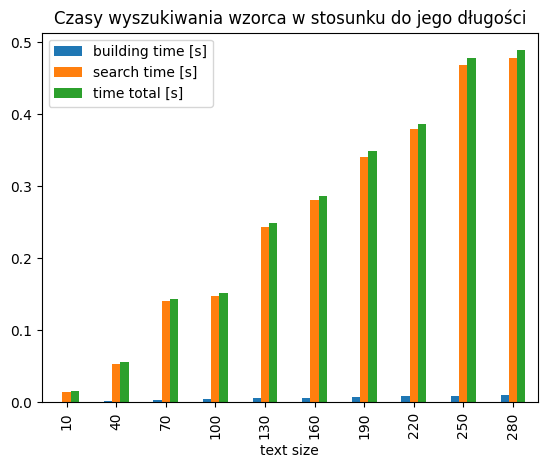

In [32]:
df.plot(x='text size', y=['building time [s]', 'search time [s]', 'time total [s]'], kind='bar')
plt.title("Czasy wyszukiwania wzorca w stosunku do jego długości")
plt.show()

## ad 7. Porównanie czasów cd.

Podziel plik na 2, 4 i 8 fragmentów (w poziomie) i porównaj czas przeszukiwania 

In [33]:
part2=convert_image("part2.png")
part4=convert_image("part4.png")
part8=convert_image("part8.png")

In [34]:
aut_time72, search_time72=search2d(haystack_img, part2, False, True)
aut_time74, search_time74=search2d(haystack_img, part4, False, True)
aut_time78, search_time78=search2d(haystack_img, part8, False, True)

In [35]:
total_time72=aut_time72+search_time72
total_time74=aut_time74+search_time74
total_time78=aut_time78+search_time78

In [36]:
sizes=[1/2, 1/4, 1/8]
search_times7 = [search_time72, search_time74, search_time78]
aut_times7 = [aut_time72, aut_time74, aut_time78]
total_times7 = [total_time72, total_time74, total_time78]
df7 = pd.DataFrame(data={"size": sizes,
                        "building time [s]": aut_times7,
                        "search time [s]": search_times7,
                        "time total [s]": total_times7,
                       })

In [37]:
display(df7)

,size,building time [s],search time [s],time total [s]
0,0.500,31.630576,101.257723,132.888299
1,0.250,16.938828,27.497939,44.436767
2,0.125,7.986828,7.174273,15.161101


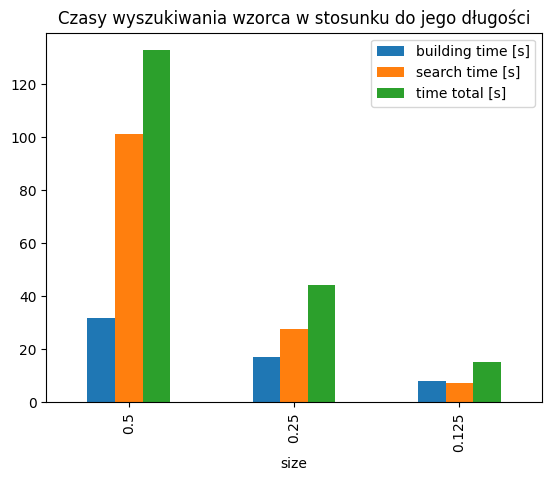

In [38]:
df7.plot(x='size', y=['building time [s]', 'search time [s]', 'time total [s]'], kind='bar')
plt.title("Czasy wyszukiwania wzorca w stosunku do jego długości")
plt.show()